In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [146]:
# Data generation

# 1) Generate synthetic dataset with controllable correlation
n = 1000
domain = [0, 1, 2,3,4,5, 6,7,8,9,10]
p_same = 1  # probability that X2 equals X1

# Sample X1 uniformly over the domain
X1 = np.random.choice(domain, size=n)

# For each X1 value, with probability p_same set X2 = X1,
# otherwise sample X2 uniformly from the other domain values
X2 = [
    x if np.random.rand() < p_same
    else np.random.choice([d for d in domain if d != x])
    for x in X1
]

# Build DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2})

# Display first few rows to confirm



#print(df.head())
#print(df['X1'].corr(df['X2']))







In [147]:
# GRR primitives ---
def grr_perturb(x, domain, epsilon):
    k = len(domain)
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    if np.random.rand() < p:
        return x
    return np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    n, k = len(reports), len(domain)
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    q = 1.0 / (np.exp(epsilon) + k - 1)
    counts = {v: 0 for v in domain}
    for r in reports:
        counts[r] += 1
    return {v: (counts[v] - n*q) / (n*(p - q)) for v in domain}


In [148]:
# --- Corrected baseline: SPL + GRR on both attrs ---
def random_split_perturb(df, domain1, domain2, epsilon):
    eps2 = epsilon / 2
    pert = []
    for _, row in df.iterrows():
        y1 = grr_perturb(row['X1'], domain1, eps2)
        y2 = grr_perturb(row['X2'], domain2, eps2)
        pert.append((y1, y2))
    return pert

def random_split_estimate(reports, domain1, domain2, epsilon):
    eps2 = epsilon / 2
    rep1 = [y1 for y1, _ in reports]
    rep2 = [y2 for _, y2 in reports]
    f1 = grr_estimate_frequencies(rep1, domain1, eps2)
    f2 = grr_estimate_frequencies(rep2, domain2, eps2)
    return f1, f2

In [153]:

# --- closed-form p_y optimizer (unchanged) ---
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1))
                 for v in domain)
    α2 =   sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2
                 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den =      a1**2/(2*n)   - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    print(p_star)
    return float(np.clip(p_star, 0.0, 1.0))


# --- RR-Corr with automatic p_y ---
def rr_corr(df, domain1, domain2, epsilon, m):
    n = len(df)
    eps2 = epsilon/2
    idx = np.random.permutation(n)
    idx_a, idx_b = idx[:m], idx[m:]

    # Phase A
    Y1_a, Y2_a = [], []
    for i in idx_a:
        x1, x2 = df.iloc[i]['X1'], df.iloc[i]['X2']
        Y1_a.append(grr_perturb(x1, domain1, eps2))
        Y2_a.append(grr_perturb(x2, domain2, eps2))
    f1_a = grr_estimate_frequencies(Y1_a, domain1, eps2)
    f2_a = grr_estimate_frequencies(Y2_a, domain2, eps2)

    # infer cov (optional)
    cov_Y = np.cov(Y1_a, Y2_a, ddof=1)[0,1]
    p_a1 = np.exp(eps2)/(np.exp(eps2)+len(domain1)-1)
    p_a2 = np.exp(eps2)/(np.exp(eps2)+len(domain2)-1)
    cov_X = cov_Y / (p_a1 * p_a2)

    # compute optimal p_y
    p_y = optimal_p_y(f1_a, f2_a, epsilon, n, domain1)
    

    # Phase B
    Y1_b, Y2_b = [], []
    for i in idx_b:
        x1, x2 = df.iloc[i]['X1'], df.iloc[i]['X2']
        if np.random.rand() < 0.5:
            y1 = grr_perturb(x1, domain1, epsilon)
            if np.random.rand() < p_y:
                y2 = y1
            else:
                y2 = np.random.choice([v for v in domain2 if v != y1])
        else:
            y2 = grr_perturb(x2, domain2, epsilon)
            if np.random.rand() < p_y:
                y1 = y2
            else:
                y1 = np.random.choice([v for v in domain1 if v != y2])
        Y1_b.append(y1)
        Y2_b.append(y2)

    f1_b = grr_estimate_frequencies(Y1_b, domain1, epsilon)
    f2_b = grr_estimate_frequencies(Y2_b, domain2, epsilon)

    hat_f1 = {v: (m*f1_a[v] + (n-m)*f1_b[v]) / n for v in domain1}
    hat_f2 = {v: (m*f2_a[v] + (n-m)*f2_b[v]) / n for v in domain2}
    return hat_f1, hat_f2, cov_X


In [154]:
# --- RS+FD [GRR] client-side perturbation ---
def rs_fd_perturb(df, domains, epsilon):
    """
    Random Sampling + Fake Data with GRR as the local randomizer.
    
    Args:
        df       : pandas.DataFrame of shape (n, d) with columns corresponding to attributes.
        domains  : dict mapping each column name to its list of possible categorical values.
        epsilon  : target privacy budget ε.
    Returns:
        pandas.DataFrame of privatized tuples y, same shape as df.
    """
    n, d = df.shape[0], len(domains)
    # Amplified privacy budget ε'
    #epsilon_prime =  np.log(d * (np.exp(epsilon) - 1) + 1)
    epsilon_prime = epsilon
    perturbed_rows = []
    cols = list(domains.keys())
    
    for _, row in df.iterrows():
        # 1) sample one attribute j uniformly
        j = np.random.randint(0, d)
        y = {}
        for idx, col in enumerate(cols):
            domain = domains[col]
            if idx == j:
                # privatize true value with GRR at ε'
                y[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                # fake uniform value
                y[col] = np.random.choice(domain)
        perturbed_rows.append(y)
    
    return pd.DataFrame(perturbed_rows, index=df.index)


# --- RS+FD [GRR] server-side aggregator ---
def rs_fd_estimate(perturbed_df, domains, epsilon):
    """
    Unbiased frequency estimates for RS+FD[GRR].
    
    Args:
        perturbed_df : DataFrame returned by rs_fd_perturb.
        domains      : dict mapping each column name to its list of possible values.
        epsilon      : target privacy budget ε (same used in rs_fd_perturb).
    Returns:
        dict mapping each column name to a dict {value: estimated frequency}.
    """
    n, d = perturbed_df.shape[0], len(domains)
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    
    freq_estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        # GRR flip probabilities at ε'
        p = np.exp(epsilon_prime) / (np.exp(epsilon_prime) + kj - 1)
        q = 1.0 / (np.exp(epsilon_prime) + kj - 1)
        
        # Count occurrences of each v in perturbed_df[col]
        counts = perturbed_df[col].value_counts().to_dict()
        
        est = {}
        for v in domain:
            Ni = counts.get(v, 0)
            # unbiased estimator: (Ni * d * kj - n * (d-1 + q*kj)) / (n * kj * (p-q))
            est[v] = (Ni * d * kj - n * (d - 1 + q * kj)) / (n * kj * (p - q))
        freq_estimates[col] = est
    
    return freq_estimates

In [155]:
# --- RS+RFD [GRR] with Phase-A SPL learning priors ---
def rr_rfd(df, domains, epsilon, m):
    """
    RS+RFD with GRR:
      Phase A: SPL (epsilon/d per attr) to learn priors.
      Phase B: RS+RFD using learnt priors & amplified GRR.
      Returns weighted final marginals per attribute.
    Args:
        df       : DataFrame with columns matching domains.keys()
        domains  : dict col -> list of values
        epsilon  : total budget ε
        m        : # of Phase-A users
    """
    n, d = len(df), len(domains)
    cols = list(domains.keys())
    
    # --- Phase A: SPL (split budget across attrs) ---
    epsA = epsilon / d
    idx = np.random.permutation(n)
    idx_a, idx_b = idx[:m], idx[m:]
    
    # learn priors f_a for each attribute
    priors = {}
    for col in cols:
        Y_a = [grr_perturb(df.iloc[i][col], domains[col], epsA) for i in idx_a]
        priors[col] = grr_estimate_frequencies(Y_a, domains[col], epsA)
    
    # --- Phase B: RS+RFD ---
    eps_prime = np.log(d*(np.exp(epsilon)-1) + 1)
    eps_prime = epsilon
    
    # collect perturbed outputs per attribute
    reports_b = {col: [] for col in cols}
    for i in idx_b:
        # choose one attribute to sanitize
        j = np.random.randint(d)
        for idx_col, col in enumerate(cols):
            if idx_col == j:
                # sanitize with GRR at eps_prime
                y = grr_perturb(df.iloc[i][col], domains[col], eps_prime)
            else:
                # realistic fake from learned prior
                prior_dist = [priors[col][v] for v in domains[col]]
                y = np.random.choice(domains[col], p=prior_dist)
            reports_b[col].append(y)
    
    # --- Server-side RS+RFD estimator per Eq.(6) ---
    f_b = {}
    for col in cols:
        domain = domains[col]
        kj = len(domain)
        p = np.exp(eps_prime) / (np.exp(eps_prime) + kj - 1)
        q = 1.0 / (np.exp(eps_prime) + kj - 1)
        
        counts = {v:0 for v in domain}
        for y in reports_b[col]:
            counts[y] += 1
        
        est = {}
        for v in domain:
            C_v = counts[v]
            est[v] = (d*C_v - n*q + (d-1)*priors[col][v]) / (n*(p - q))
        f_b[col] = est
    
    # --- Combine weighted marginals ---
    final = {}
    for col in cols:
        final[col] = {
            v: (m*priors[col][v] + (n-m)*f_b[col][v]) / n
            for v in domains[col]
        }
    
    return final

def rs_rfd_full_prior(df, domains, epsilon):
    """
    Random Sampling + Realistic Fake Data (single phase, full prior).
    
    Args:
      df      : DataFrame, each column an attribute.
      domains : dict col -> list of values.
      epsilon : target LDP budget ε.
    
    Returns:
      f_hat : dict col -> {value: estimated marginal frequency}.
    """
    n, d = len(df), len(domains)
    # amplified budget
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    epsilon_prime = epsilon
    # 1) compute true priors from full df
    priors = {}
    for col, domain in domains.items():
        counts = df[col].value_counts(normalize=True).reindex(domain, fill_value=0)
        priors[col] = counts.tolist()
    
    # 2) client‐side: generate perturbed tuples
    reports = {col: [] for col in domains}
    for _, row in df.iterrows():
        j = np.random.randint(d)  # sampled attribute
        for idx, col in enumerate(domains):
            domain = domains[col]
            if idx == j:
                # sanitize with GRR at ε′
                y = grr_perturb(row[col], domain, epsilon_prime)
            else:
                # realistic fake from full-data prior
                y = np.random.choice(domain, p=priors[col])
            reports[col].append(y)
    
    # 3) server‐side estimator per Eq.(6)
    f_hat = {}
    for col, domain in domains.items():
        kj = len(domain)
        p = np.exp(epsilon_prime) / (np.exp(epsilon_prime) + kj - 1)
        q = 1.0 / (np.exp(epsilon_prime) + kj - 1)
        f_prior = dict(zip(domain, priors[col]))
        
        # count occurrences
        counts = pd.Series(reports[col]).value_counts().to_dict()
        
        est = {}
        for v in domain:
            C_v = counts.get(v, 0)
            est[v] = (d*C_v - n*q + (d-1)*f_prior[v]) / (n*(p - q))
        f_hat[col] = est
    
    return f_hat


-5.242624757065202
-8.379371035788802
15.230503211807498


<Figure size 576x360 with 0 Axes>

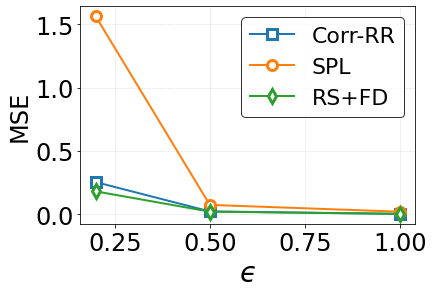

In [156]:
# --- MSE vs ε plot ---
domain      = sorted(df['X1'].unique())
true_freq1  = df['X1'].value_counts(normalize=True).sort_index().to_dict()
true_freq2  = df['X2'].value_counts(normalize=True).sort_index().to_dict()
n           = len(df)
m           = int(0.1 * n)
domains     = {'X1': domain, 'X2': domain}

epsilons      = [0.2, 0.5, 1]
mse_rrcorr    = []
mse_baseline  = []
mse_rsfd      = []

for eps in epsilons:
    # 1) Corr-RR
    hat1, hat2, _ = rr_corr(df, domain, domain, eps, m)
    mse1 = np.mean([(hat1[v] - true_freq1[v])**2 for v in domain])
    mse2 = np.mean([(hat2[v] - true_freq2[v])**2 for v in domain])
    mse_rrcorr.append((mse1 + mse2) / 2)

    # 2) SPL baseline
    pert  = random_split_perturb(df, domain, domain, eps)
    est1, est2 = random_split_estimate(pert, domain, domain, eps)
    mse1_s = np.mean([(est1[v] - true_freq1[v])**2 for v in domain])
    mse2_s = np.mean([(est2[v] - true_freq2[v])**2 for v in domain])
    mse_baseline.append((mse1_s + mse2_s) / 2)

    # 3) RS+FD[GRR]
    pert_rsfd = rs_fd_perturb(df, domains, eps)
    ests_rsfd = rs_fd_estimate(pert_rsfd, domains, eps)
    # unpack and compute MSE per attribute
    mse_attrs = []
    for col, true_f in zip(['X1','X2'], [true_freq1, true_freq2]):
        est = ests_rsfd[col]
        mse_attrs.append(np.mean([(est[v] - true_f[v])**2 for v in domain]))
    mse_rsfd.append(np.mean(mse_attrs))

# --- plot all three ---
markers = ['s', 'o', 'd', 'x']
plt.figure(figsize=(8, 5))
plt.figure(figsize=(6,4))
plt.plot(epsilons, mse_rrcorr,linewidth=2, marker=markers[0], markersize=10, markeredgewidth=3, markerfacecolor='white', alpha=1, label='Corr-RR')
plt.plot(epsilons, mse_baseline, linewidth=2, marker=markers[1],markersize=10, markeredgewidth=3, markerfacecolor='white', alpha=1, label='SPL')
plt.plot(epsilons, mse_rsfd,  linewidth=2, marker=markers[2],markersize=10, markeredgewidth=3, markerfacecolor='white', alpha=1,label='RS+FD')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    # Set the y-axis to use scientific notation
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel(r'$\mathit{ϵ}$', fontsize=28)
plt.ylabel('MSE', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.legend(fontsize=22, loc='upper right', frameon=True, edgecolor='black', fancybox=True)
plt.grid(True)
plt.show()


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Generate or load df:
n = 100
domain = [0, 1, 2,3,4,5, 6,7,8,9,10]
p_same = 0.95  # probability that X2 equals X1
X1 = np.random.choice(domain, size=n)
X2 = [x if np.random.rand() < p_same else np.random.choice([d for d in domain if d!=x]) for x in X1]
df = pd.DataFrame({'X1': X1, 'X2': X2})

# 2) Prepare supporting variables:
domains = {'X1': domain, 'X2': domain}
true_freq1  = df['X1'].value_counts(normalize=True).sort_index().to_dict()
true_freq2  = df['X2'].value_counts(normalize=True).sort_index().to_dict()
m = int(0.1 * len(df))
epsilons = [1.0, 2, 3]

# Initialize MSE lists
mse_rrcorr = []
mse_baseline = []
mse_rsfd = []
mse_rsrfd = []

for eps in epsilons:
    # 1) Corr-RR
    hat1, hat2, _ = rr_corr(df, domain, domain, eps, m)
    mse1 = np.mean([(hat1[v] - true_freq1[v])**2 for v in domain])
    mse2 = np.mean([(hat2[v] - true_freq2[v])**2 for v in domain])
    mse_rrcorr.append((mse1 + mse2) / 2)

    # 2) SPL baseline
    pert  = random_split_perturb(df, domain, domain, eps)
    est1, est2 = random_split_estimate(pert, domain, domain, eps)
    mse1_s = np.mean([(est1[v] - true_freq1[v])**2 for v in domain])
    mse2_s = np.mean([(est2[v] - true_freq2[v])**2 for v in domain])
    mse_baseline.append((mse1_s + mse2_s) / 2)

    # 3) RS+FD[GRR]
    pert_rsfd = rs_fd_perturb(df, domains, eps)
    ests_rsfd = rs_fd_estimate(pert_rsfd, domains, eps)
    mse_attrs = []
    for col, true_f in zip(['X1','X2'], [true_freq1, true_freq2]):
        est = ests_rsfd[col]
        mse_attrs.append(np.mean([(est[v] - true_f[v])**2 for v in domain]))
    mse_rsfd.append(np.mean(mse_attrs))

    # 4) RS+RFD[GRR]
    final_rsrfd = rr_rfd(df, domains, eps, m)
    mse1_rr = np.mean([(final_rsrfd['X1'][v] - true_freq1[v])**2 for v in domain])
    mse2_rr = np.mean([(final_rsrfd['X2'][v] - true_freq2[v])**2 for v in domain])
    mse_rsrfd.append((mse1_rr + mse2_rr) / 2)

# Plot all four mechanisms
plt.figure(figsize=(6,4))
plt.plot(epsilons, mse_rrcorr,  'o-', label='Corr-RR')
plt.plot(epsilons, mse_baseline,'x--', label='SPL')
plt.plot(epsilons, mse_rsfd,    's-.', label='RS+FD')
plt.plot(epsilons, mse_rsrfd,   'd:',  label='RS+RFD')
plt.xlabel(r'$\mathit{ϵ}$', fontsize=14)
plt.ylabel('Overall MSE', fontsize=14)
plt.title('MSE vs. ε for Different LDP Mechanisms', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


ValueError: probabilities are not non-negative

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all functions (rr_corr, random_split_perturb, random_split_estimate,
# rs_fd_perturb, rs_fd_estimate, rr_rfd, rs_rfd_full_prior) and df, domains, domain,
# true_freq1, true_freq2, n, m have been defined previously.

# Add a new list for the single-phase RS+RFD with full-data prior
mse_rsrfd_full = []

epsilons = [0.2, 0.3, 0.5]
mse_rrcorr = []
mse_baseline = []
mse_rsfd = []
mse_rsrfd = []

for eps in epsilons:
    # 1) Corr-RR
    hat1, hat2, _ = rr_corr(df, domain, domain, eps, m)
    mse_rrcorr.append(np.mean([(hat1[v] - true_freq1[v])**2 for v in domain] +
                              [(hat2[v] - true_freq2[v])**2 for v in domain]) / 2)

    # 2) SPL baseline
    pert = random_split_perturb(df, domain, domain, eps)
    est1, est2 = random_split_estimate(pert, domain, domain, eps)
    mse_baseline.append(np.mean([(est1[v] - true_freq1[v])**2 for v in domain] +
                                [(est2[v] - true_freq2[v])**2 for v in domain]) / 2)

    # 3) RS+FD[GRR]
    pert_rsfd = rs_fd_perturb(df, domains, eps)
    ests_rsfd = rs_fd_estimate(pert_rsfd, domains, eps)
    mse_rsfd.append(np.mean([(ests_rsfd['X1'][v] - true_freq1[v])**2 for v in domain] +
                            [(ests_rsfd['X2'][v] - true_freq2[v])**2 for v in domain]) / 2)

    # 4) RS+RFD two-phase
    final_rsrfd = rr_rfd(df, domains, eps, m)
    mse_rsrfd.append(np.mean([(final_rsrfd['X1'][v] - true_freq1[v])**2 for v in domain] +
                              [(final_rsrfd['X2'][v] - true_freq2[v])**2 for v in domain]) / 2)

    # 5) RS+RFD single-phase with full-data prior
    f_hat_full = rs_rfd_full_prior(df, domains, eps)
    mse_rsrfd_full.append(np.mean([(f_hat_full['X1'][v] - true_freq1[v])**2 for v in domain] +
                                   [(f_hat_full['X2'][v] - true_freq2[v])**2 for v in domain]) / 2)

# Plotting all five curves
plt.figure(figsize=(6,4))
plt.plot(epsilons, mse_rrcorr,   'o-', label='Corr-RR')
plt.plot(epsilons, mse_baseline, 'x--', label='SPL')
plt.plot(epsilons, mse_rsfd,     's-.', label='RS+FD')
plt.plot(epsilons, mse_rsrfd,    'd:',  label='RS+RFD (2-phase)')
plt.plot(epsilons, mse_rsrfd_full, 'v--', label='RS+RFD (full prior)')

plt.xlabel(r'$\epsilon$', fontsize=14)
plt.ylabel('Overall MSE', fontsize=14)
plt.title('MSE vs. ε for LDP Mechanisms including full-prior RS+RFD', fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


ValueError: probabilities are not non-negative

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Number of Monte Carlo runs
n_runs = 10

# Privacy parameters to sweep
epsilons = [1.0, 2.0, 3.0]

# Initialize accumulators for each mechanism
mse_rrcorr_acc = np.zeros(len(epsilons))
mse_spl_acc    = np.zeros(len(epsilons))
mse_rsfd_acc   = np.zeros(len(epsilons))

# Run multiple trials to average out randomness
for run in range(n_runs):
    for idx, eps in enumerate(epsilons):
        # 1) Corr-RR
        hat1, hat2, _ = rr_corr(df, domain, domain, eps, m)
        mse_rr = np.mean([(hat1[v] - true_freq1[v])**2 for v in domain] +
                         [(hat2[v] - true_freq2[v])**2 for v in domain]) / 2
        mse_rrcorr_acc[idx] += mse_rr

        # 2) SPL baseline
        pert = random_split_perturb(df, domain, domain, eps)
        est1, est2 = random_split_estimate(pert, domain, domain, eps)
        mse_sp = np.mean([(est1[v] - true_freq1[v])**2 for v in domain] +
                         [(est2[v] - true_freq2[v])**2 for v in domain]) / 2
        mse_spl_acc[idx] += mse_sp

        # 3) RS+FD[GRR]
        pert_fd = rs_fd_perturb(df, domains, eps)
        ests_fd = rs_fd_estimate(pert_fd, domains, eps)
        mse_fd = np.mean([(ests_fd['X1'][v] - true_freq1[v])**2 for v in domain] +
                         [(ests_fd['X2'][v] - true_freq2[v])**2 for v in domain]) / 2
        mse_rsfd_acc[idx] += mse_fd

# Compute averages
mse_rrcorr_avg = mse_rrcorr_acc / n_runs
mse_spl_avg    = mse_spl_acc    / n_runs
mse_rsfd_avg   = mse_rsfd_acc   / n_runs

# Plot averaged MSE vs ε
plt.figure(figsize=(6,4))
plt.plot(epsilons, mse_rrcorr_avg, 'o-', label='Corr-RR (avg over 10 runs)')
plt.plot(epsilons, mse_spl_avg,    'x--', label='SPL baseline (avg over 10 runs)')
plt.plot(epsilons, mse_rsfd_avg,   's-.', label='RS+FD (avg over 10 runs)')
plt.xlabel(r'$\epsilon$', fontsize=14)
plt.ylabel('Average Overall MSE', fontsize=14)
plt.title('Average MSE vs ε (10 runs)', fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


KeyError: 4

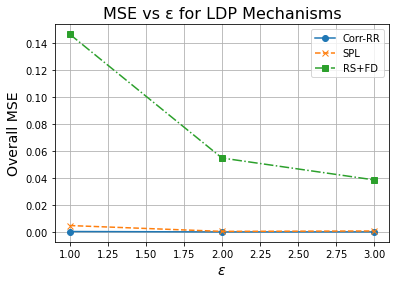

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1) Generate synthetic dataset
# ------------------------------
n = 1000
domain = [0, 1, 2, 3]
p_same = 0.95
X1 = np.random.choice(domain, size=n)
X2 = [x if np.random.rand() < p_same else np.random.choice([d for d in domain if d != x]) for x in X1]
df = pd.DataFrame({'X1': X1, 'X2': X2})

# True marginals
true_freq1 = df['X1'].value_counts(normalize=True).sort_index().to_dict()
true_freq2 = df['X2'].value_counts(normalize=True).sort_index().to_dict()

# Domains mapping
domains = {'X1': domain, 'X2': domain}

# -----------------------------------
# 2) Define GRR primitives and utils
# -----------------------------------
def grr_perturb(x, domain, epsilon):
    k = len(domain)
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    if np.random.rand() < p:
        return x
    return np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    n, k = len(reports), len(domain)
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    q = 1.0 / (np.exp(epsilon) + k - 1)
    counts = {v: 0 for v in domain}
    for r in reports:
        counts[r] += 1
    return {v: (counts[v] - n*q) / (n*(p - q)) for v in domain}

# ---------------------------
# 3) SPL baseline functions
# ---------------------------
def random_split_perturb(df, dom1, dom2, epsilon):
    eps2 = epsilon / 2
    pert = []
    for _, row in df.iterrows():
        y1 = grr_perturb(row['X1'], dom1, eps2)
        y2 = grr_perturb(row['X2'], dom2, eps2)
        pert.append((y1, y2))
    return pert

def random_split_estimate(reports, dom1, dom2, epsilon):
    eps2 = epsilon / 2
    rep1 = [y1 for y1, _ in reports]
    rep2 = [y2 for _, y2 in reports]
    f1 = grr_estimate_frequencies(rep1, dom1, eps2)
    f2 = grr_estimate_frequencies(rep2, dom2, eps2)
    return f1, f2

# ----------------------------
# 4) RR-Corr with auto p_y
# ----------------------------
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1))
                 for v in domain)
    α2 =   sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2
                 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den =      a1**2/(2*n)   - α2/(4*d)
    p_star = num/den if den != 0 else 0.0
    return float(np.clip(p_star, 0.0, 1.0))

def rr_corr(df, dom1, dom2, epsilon, m):
    n = len(df)
    eps2 = epsilon / 2
    idx = np.random.permutation(n)
    idx_a, idx_b = idx[:m], idx[m:]

    # Phase A
    Y1_a, Y2_a = [], []
    for i in idx_a:
        x1, x2 = df.iloc[i]['X1'], df.iloc[i]['X2']
        Y1_a.append(grr_perturb(x1, dom1, eps2))
        Y2_a.append(grr_perturb(x2, dom2, eps2))
    f1_a = grr_estimate_frequencies(Y1_a, dom1, eps2)
    f2_a = grr_estimate_frequencies(Y2_a, dom2, eps2)

    # compute p_y
    p_y = optimal_p_y(f1_a, f2_a, epsilon, n, dom1)

    # Phase B
    Y1_b, Y2_b = [], []
    for i in idx_b:
        x1, x2 = df.iloc[i]['X1'], df.iloc[i]['X2']
        if np.random.rand() < 0.5:
            y1 = grr_perturb(x1, dom1, epsilon)
            y2 = y1 if np.random.rand() < p_y else np.random.choice([v for v in dom2 if v != y1])
        else:
            y2 = grr_perturb(x2, dom2, epsilon)
            y1 = y2 if np.random.rand() < p_y else np.random.choice([v for v in dom1 if v != y2])
        Y1_b.append(y1)
        Y2_b.append(y2)
    f1_b = grr_estimate_frequencies(Y1_b, dom1, epsilon)
    f2_b = grr_estimate_frequencies(Y2_b, dom2, epsilon)

    hat_f1 = {v: (m*f1_a[v] + (n-m)*f1_b[v]) / n for v in dom1}
    hat_f2 = {v: (m*f2_a[v] + (n-m)*f2_b[v]) / n for v in dom2}
    return hat_f1, hat_f2, None  # cov not used here

# --------------------
# 5) RS+FD functions
# --------------------
def rs_fd_perturb(df, domains, epsilon):
    n, d = len(df), len(domains)
    eps_prime = np.log(d*(np.exp(epsilon)-1) + 1)
    #eps_prime = epsilon
    rows = []
    for _, row in df.iterrows():
        j = np.random.randint(d)
        y = {}
        for idx, col in enumerate(domains):
            if idx == j:
                y[col] = grr_perturb(row[col], domains[col], eps_prime)
            else:
                y[col] = np.random.choice(domains[col])
        rows.append(y)
    return pd.DataFrame(rows, index=df.index)

def rs_fd_estimate(pert_df, domains, epsilon):
    n, d = len(pert_df), len(domains)
    eps_prime = np.log(d*(np.exp(epsilon)-1) + 1)
    #eps_prime = epsilon
    result = {}
    for col in domains:
        domain = domains[col]
        kj = len(domain)
        p = np.exp(eps_prime)/(np.exp(eps_prime)+kj-1)
        q = 1.0/(np.exp(eps_prime)+kj-1)
        counts = pert_df[col].value_counts().to_dict()
        est = {}
        for v in domain:
            C_v = counts.get(v, 0)
            est[v] = (d*C_v - n*q) / (n*(p - q))
        result[col] = est
    return result

def rr_rfd(df, domains, epsilon, m):
    n, d = len(df), len(domains)

    # Phase A budget
    epsA = epsilon / d
    idx = np.random.permutation(n)
    idx_a, idx_b = idx[:m], idx[m:]

    # 1) Phase A: learn GRR‐noised priors
    priors = {}
    for col, domain in domains.items():
        # get noisy reports
        Y = [grr_perturb(df.iloc[i][col], domain, epsA) for i in idx_a]
        # estimate marginal
        est = grr_estimate_frequencies(Y, domain, epsA)
        # clip & normalize
        raw = np.array([est[v] for v in domain])
        clipped = np.clip(raw, 0.0, None)
        total = clipped.sum()
        if total > 0:
            priors[col] = (clipped / total).tolist()
        else:
            priors[col] = np.ones_like(clipped) / len(domain)
    cols = list(domains)

    # Phase B amplification
    #eps_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    eps_prime = epsilon
    reports = {col: [] for col in cols}

    # 2) Phase B: RS+RFD with realistic fakes
    for i in idx_b:
        j = np.random.randint(d)
        for idx_col, col in enumerate(cols):
            domain = domains[col]
            if idx_col == j:
                # true attribute → GRR
                y = grr_perturb(df.iloc[i][col], domain, eps_prime)
            else:
                # fake attribute → sample from cleaned prior
                y = np.random.choice(domain, p=priors[col])
            reports[col].append(y)

    # 3) Estimate f̂_B via RS+RFD[GRR] Eq.(6)
    f_b = {}
    for col, domain in domains.items():
        kj = len(domain)
        p = np.exp(eps_prime)/(np.exp(eps_prime)+kj-1)
        q = 1.0/(np.exp(eps_prime)+kj-1)
        counts = pd.Series(reports[col]).value_counts().to_dict()

        fb = {}
        for v in domain:
            C_v = counts.get(v, 0)
            # use the *cleaned* prior from Phase A:
            ftilde = priors[col][domain.index(v)]
            fb[v] = (d*C_v - n*q + (d-1)*ftilde) / (n*(p - q))
        f_b[col] = fb

    # 4) Weighted combine Phase A & B
    final = {}
    for col, domain in domains.items():
        # Phase A’s estimate was prios[col]; Phase B’s is f_b[col]
        final[col] = {
            v: (m*priors[col][domain.index(v)] + (n-m)*f_b[col][v]) / n
            for v in domain
        }
    return final


# -------------------------------------
# 7) Single-phase RS+RFD w/ full-data prior FIXED
# -------------------------------------
def rs_rfd_full_prior(df, domains, epsilon):
    n, d = len(df), len(domains)
    #eps_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    eps_prime = epsilon
    cols = list(domains)

    # 1) compute exact priors from *true* df
    priors = {}
    for col, domain in domains.items():
        counts = df[col].value_counts(normalize=True).reindex(domain, fill_value=0).values
        priors[col] = counts  # already non-negative, sums to 1

    # 2) client‐side perturb/fakes
    reports = {col: [] for col in cols}
    for _, row in df.iterrows():
        j = np.random.randint(d)
        for idx_col, col in enumerate(cols):
            domain = domains[col]
            if idx_col == j:
                y = grr_perturb(row[col], domain, eps_prime)
            else:
                y = np.random.choice(domain, p=priors[col])
            reports[col].append(y)

    # 3) unbiased estimation (same as above)
    f_hat = {}
    for col, domain in domains.items():
        kj = len(domain)
        p = np.exp(eps_prime)/(np.exp(eps_prime)+kj-1)
        q = 1.0/(np.exp(eps_prime)+kj-1)
        counts = pd.Series(reports[col]).value_counts().to_dict()

        est = {}
        for v in domain:
            C_v = counts.get(v, 0)
            ftilde = priors[col][domain.index(v)]
            est[v] = (d*C_v - n*q + (d-1)*ftilde) / (n*(p - q))
        f_hat[col] = est

    return f_hat
# ------------------------------
# 8) MSE vs. ε for all methods
# ------------------------------
m = int(0.1 * n)
epsilons = [1,2,3]
mse_rrcorr = []
mse_spl    = []
mse_rsfd   = []
mse_rsrfd  = []
mse_full   = []

for eps in epsilons:
    # Corr-RR
    hat1, hat2, _ = rr_corr(df, domain, domain, eps, m)
    mse_rrcorr.append(np.mean([(hat1[v]-true_freq1[v])**2 for v in domain] +
                              [(hat2[v]-true_freq2[v])**2 for v in domain]) / 2)
    # SPL baseline
    pert = random_split_perturb(df, domain, domain, eps)
    est1, est2 = random_split_estimate(pert, domain, domain, eps)
    mse_spl.append(np.mean([(est1[v]-true_freq1[v])**2 for v in domain] +
                           [(est2[v]-true_freq2[v])**2 for v in domain]) / 2)
    # RS+FD
    pert_fd = rs_fd_perturb(df, domains, eps)
    ests_fd = rs_fd_estimate(pert_fd, domains, eps)
    mse_rsfd.append(np.mean([(ests_fd['X1'][v]-true_freq1[v])**2 for v in domain] +
                             [(ests_fd['X2'][v]-true_freq2[v])**2 for v in domain]) / 2)
#     # RS+RFD two-phase
#     final_rfd = rr_rfd(df, domains, eps, m)
#     mse_rsrfd.append(np.mean([(final_rfd['X1'][v]-true_freq1[v])**2 for v in domain] +
#                              [(final_rfd['X2'][v]-true_freq2[v])**2 for v in domain]) / 2)
#     # RS+RFD full prior
#     full_est = rs_rfd_full_prior(df, domains, eps)
#     mse_full.append(np.mean([(full_est['X1'][v]-true_freq1[v])**2 for v in domain] +
#                             [(full_est['X2'][v]-true_freq2[v])**2 for v in domain]) / 2)

# Plot
plt.figure(figsize=(6,4))
plt.plot(epsilons, mse_rrcorr, 'o-', label='Corr-RR')
plt.plot(epsilons, mse_spl,    'x--', label='SPL')
plt.plot(epsilons, mse_rsfd,   's-.', label='RS+FD')
# plt.plot(epsilons, mse_rsrfd,  'd:',  label='RS+RFD (2-phase)')
# plt.plot(epsilons, mse_full,   'v--', label='RS+RFD (full prior)')
plt.xlabel(r'$\epsilon$', fontsize=14)
plt.ylabel('Overall MSE', fontsize=14)
plt.title('MSE vs ε for LDP Mechanisms', fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


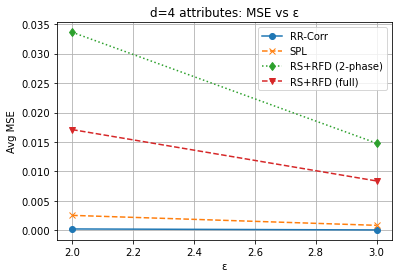

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1) Synthetic data: 4 correlated attrs X1-X2 and X3-X4, domain = {0,1,2,3}
# -----------------------------------------------------------------------------
n = 5000
domain = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# generate correlated pairs
p12, p34 = 1, 1
X1 = np.random.choice(domain, size=n)
X2 = [x if np.random.rand()<p12 else np.random.choice([d for d in domain if d!=x]) for x in X1]
X3 = np.random.choice(domain, size=n)
X4 = [x if np.random.rand()<p34 else np.random.choice([d for d in domain if d!=x]) for x in X3]
df = pd.DataFrame(dict(X1=X1, X2=X2, X3=X3, X4=X4))
cols = list(df.columns)
domains = {c: domain for c in cols}

# true marginals
true_freq = {
    c: df[c].value_counts(normalize=True).sort_index().to_dict()
    for c in cols
}

# -----------------------------------------------------------------------------
# 2) GRR primitives
# -----------------------------------------------------------------------------
def grr_perturb(x, domain, eps):
    k = len(domain)
    p = np.exp(eps)/(np.exp(eps)+k-1)
    if np.random.rand() < p:
        return x
    return np.random.choice([v for v in domain if v!=x])

def grr_estimate(reps, domain, eps):
    n, k = len(reps), len(domain)
    p = np.exp(eps)/(np.exp(eps)+k-1)
    q = 1/(np.exp(eps)+k-1)
    cnt = {v:0 for v in domain}
    for r in reps: cnt[r]+=1
    return {v:(cnt[v]-n*q)/(n*(p-q)) for v in domain}

# -----------------------------------------------------------------------------
# 3) SPL baseline (each attr @ ε/d)
# -----------------------------------------------------------------------------
def spl_perturb(df, domains, eps):
    d = len(domains)
    eps_j = eps/d
    out = {c:[] for c in domains}
    for _,row in df.iterrows():
        for c,dom in domains.items():
            out[c].append(grr_perturb(row[c], dom, eps_j))
    return out

def spl_estimate(pert, domains, eps):
    d = len(domains); eps_j = eps/d
    return {c: grr_estimate(pert[c], domains[c], eps_j) for c in domains}

# -----------------------------------------------------------------------------
# 4) RR-Corr generalized
# -----------------------------------------------------------------------------
def optimal_p_y(fa, fb, eps, n, domain):
    # same as before
    d=len(domain); expE=np.exp(eps)
    p=expE/(expE+d-1); q=1/(expE+d-1); Δ=p-q
    S1=d*(d-1)/2; S2=(d-1)*d*(2*d-1)/6
    μa=sum(v*fa[v] for v in domain)
    μb=sum(v*fb[v] for v in domain)
    νb2=sum(v*v*fb[v] for v in domain)
    a0=μa-μb; a1=2*μb-S1; b1=2*νb2-S2; Y0=(Δ/2)*a0+S1/2
    α1=2*sum((1-fa[v]-fb[v])*((2*fa[v]-1)+(2*fb[v]-1)) for v in domain)
    α2=sum((2*fa[v]-1)**2+(2*fb[v]-1)**2 for v in domain)
    num=(b1-2*Y0*a1)/(2*n*Δ)+α1/(8*d)
    den= a1*a1/(2*n)-α2/(4*d)
    return float(np.clip(num/den if den else 0,0,1))

def rr_corr_multi(df, domains, eps, m):
    n=len(df); cols=list(domains); d=len(cols)
    idx=np.random.permutation(n); A,B=idx[:m],idx[m:]
    # Phase A @ eps/d
    epsA=eps/d
    fa={c: grr_estimate(
            [grr_perturb(df.iloc[i][c],domains[c],epsA) for i in A],
            domains[c],epsA)
        for c in cols}
    # pairwise p_y
    py={}
    for i in range(d):
        for j in range(d):
            if i==j: continue
            ci, cj=cols[i],cols[j]
            py[(ci,cj)] = optimal_p_y(fa[ci],fa[cj],eps,n,domains[ci])
    # Phase B
    reps={c:[] for c in cols}
    for i in B:
        j=np.random.randint(d); cj=cols[j]
        yj=grr_perturb(df.iloc[i][cj],domains[cj],eps)
        reps[cj].append(yj)
        for k in range(d):
            if k==j: continue
            ck=cols[k]; pjk=py[(cj,ck)]
            if np.random.rand()<pjk:
                reps[ck].append(yj)
            else:
                # choose != yj if possible
                dom=domains[ck]
                alt=[v for v in dom if v!=yj]
                reps[ck].append(np.random.choice(alt) if alt else np.random.choice(dom))
    fb={c:grr_estimate(reps[c],domains[c],eps) for c in cols}
    # combine
    return {
      c:{v:(m*fa[c][v]+(n-m)*fb[c][v])/n for v in domains[c]}
      for c in cols
    }

# -----------------------------------------------------------------------------
# 5) RS+FD generalized
# -----------------------------------------------------------------------------
def rs_fd_multi(df, domains, eps):
    n=len(df); cols=list(domains); d=len(cols)
    epsP=np.log(d*(np.exp(eps)-1)+1)
    reps={c:[] for c in cols}
    for _,row in df.iterrows():
        j=np.random.randint(d)
        for k,c in enumerate(cols):
            reps[c].append(
              grr_perturb(row[c],domains[c],epsP) if k==j
              else np.random.choice(domains[c])
            )
    # unbiased per‐attr GRR est @ epsP
    return {c: grr_estimate(reps[c],domains[c],epsP) for c in cols}

# -----------------------------------------------------------------------------
# 6) RS+RFD two-phase generalized
# -----------------------------------------------------------------------------
def rs_rfd_two_phase(df, domains, eps, m):
    n=len(df); cols=list(domains); d=len(cols)
    # Phase A @ eps/d
    epsA=eps/d
    idx=np.random.permutation(n); A,B=idx[:m],idx[m:]
    # learn priors, clip+norm
    priors={}
    for c in cols:
        raw = np.array(list(grr_estimate(
            [grr_perturb(df.iloc[i][c],domains[c],epsA) for i in A],
            domains[c],epsA
        ).values()))
        clipped=np.clip(raw,0,None)
        S=clipped.sum()
        priors[c]=(clipped/S if S>0 else np.ones_like(clipped)/len(clipped))
    # Phase B RS+RFD
    epsP=np.log(d*(np.exp(eps)-1)+1)
    reps={c:[] for c in cols}
    for i in B:
        j=np.random.randint(d)
        for k,c in enumerate(cols):
            if k==j:
                reps[c].append(grr_perturb(df.iloc[i][c],domains[c],epsP))
            else:
                reps[c].append(np.random.choice(domains[c],p=priors[c]))
    # estimate @ epsP with priors
    fb={}
    for c in cols:
        kj=len(domains[c])
        p=np.exp(epsP)/(np.exp(epsP)+kj-1)
        q=1/(np.exp(epsP)+kj-1)
        cnts=pd.Series(reps[c]).value_counts().to_dict()
        pr=priors[c]
        fb[c]={v:(d*cnts.get(v,0)-n*q+(d-1)*pr[i])/(n*(p-q))
               for i,v in enumerate(domains[c])}
    # combine
    return {
      c:{v:(m*priors[c][i]+(n-m)*fb[c][v])/n
         for i,v in enumerate(domains[c])}
      for c in cols
    }

# -----------------------------------------------------------------------------
# 7) RS+RFD single-phase full prior generalized
# -----------------------------------------------------------------------------
def rs_rfd_full(df, domains, eps):
    n=len(df); cols=list(domains); d=len(cols)
    epsP=np.log(d*(np.exp(eps)-1)+1)
    # true priors
    priors={c:df[c].value_counts(normalize=True)
               .reindex(domains[c],fill_value=0).values
            for c in cols}
    reps={c:[] for c in cols}
    for _,r in df.iterrows():
        j=np.random.randint(d)
        for k,c in enumerate(cols):
            if k==j:
                reps[c].append(grr_perturb(r[c],domains[c],epsP))
            else:
                reps[c].append(np.random.choice(domains[c],p=priors[c]))
    # estimate
    fb={}
    for c in cols:
        kj=len(domains[c])
        p=np.exp(epsP)/(np.exp(epsP)+kj-1)
        q=1/(np.exp(epsP)+kj-1)
        cnts=pd.Series(reps[c]).value_counts().to_dict()
        pr=priors[c]
        fb[c]={v:(d*cnts.get(v,0)-n*q+(d-1)*pr[i])/(n*(p-q))
               for i,v in enumerate(domains[c])}
    return fb

# -----------------------------------------------------------------------------
# 8) MSE vs ε (Monte Carlo)
# -----------------------------------------------------------------------------
def mse_curve(method, label, epsilons, runs=1):
    acc = np.zeros(len(epsilons))
    for _ in range(runs):
        for i,eps in enumerate(epsilons):
            est = method(df, domains, eps, m) if label in ['RR-Corr','RS+RFD2'] \
                  else method(df, domains, eps)
            # SPL returns dict-of-dicts
            if label=='SPL': fb=est
            else: fb=est
            acc[i] += np.mean([
                (fb[c][v] - true_freq[c][v])**2
                for c in cols for v in domains[c]
            ])/len(cols)
    return acc/runs

m = int(0.1*n)
epsilons = [2.0, 3.0]

plt.figure(figsize=(6,4))
plt.plot(epsilons, mse_curve(rr_corr_multi,'RR-Corr',    epsilons),'o-', label='RR-Corr')
plt.plot(epsilons, mse_curve(spl_estimate,'SPL',         epsilons),'x--', label='SPL')
#plt.plot(epsilons, mse_curve(rs_fd_multi,'RS+FD',       epsilons),'s-.', label='RS+FD')
plt.plot(epsilons, mse_curve(rs_rfd_two_phase,'RS+RFD2',epsilons),'d:',  label='RS+RFD (2-phase)')
plt.plot(epsilons, mse_curve(rs_rfd_full,'RS+RFD1',     epsilons),'v--', label='RS+RFD (full)')
plt.xlabel('ε'); plt.ylabel('Avg MSE'); plt.legend(); plt.grid(True)
plt.title('d=4 attributes: MSE vs ε')
plt.show()


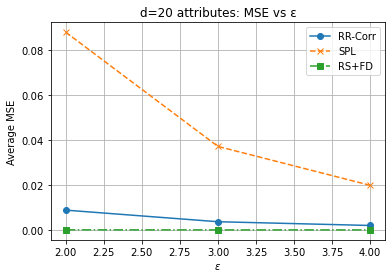

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# 0) CONFIGURE YOUR SETUP
# --------------------------
n = 5000            # number of users
d = 20               # number of attributes
domain = list(range(100))    # e.g. values 0..4
# specify which pairs to correlate and their p_same
# e.g. (0,1) means X1–X2 correlated with prob p12
corr_pairs = {
    (0,1): 1,
    (1,2): 1,
    (2,3): 1,
        # all others independent
}
# build column names
cols = [f"X{i+1}" for i in range(d)]
domains = {c: domain for c in cols}

# --------------------------
# 1) SYNTHETIC DATA GENERATION
# --------------------------
# a) uniform for all attrs
data = {c: None for c in cols}

# b) track parent correlation: for each child index j, store (i, p)
parent = {j:(i,p) for (i,j),p in corr_pairs.items()}

# generate
for idx, col in enumerate(cols):
    if idx in parent:
        i, p = parent[idx]
        base = data[cols[i]]
        # correlate to base
        data[col] = [
            x if np.random.rand() < p
            else np.random.choice([v for v in domain if v!=x])
            for x in base
        ]
    else:
        data[col] = np.random.choice(domain, size=n)

df = pd.DataFrame(data)

# true marginals (for MSE)
true_freq = {
    c: df[c].value_counts(normalize=True).sort_index().to_dict()
    for c in cols
}

# -----------------------------------
# 2) GRR PRIMITIVES
# -----------------------------------
def grr_perturb(x, domain, eps):
    k = len(domain)
    p = np.exp(eps)/(np.exp(eps)+k-1)
    if np.random.rand()<p:
        return x
    return np.random.choice([v for v in domain if v!=x])

def grr_estimate(reps, domain, eps):
    n,k = len(reps), len(domain)
    p = np.exp(eps)/(np.exp(eps)+k-1)
    q = 1/(np.exp(eps)+k-1)
    cnt = {v:0 for v in domain}
    for r in reps: cnt[r]+=1
    return {v:(cnt[v]-n*q)/(n*(p-q)) for v in domain}

# -----------------------------------
# 3) SPL BASELINE (ε/d on each)
# -----------------------------------
def spl_perturb(df, domains, eps):
    d = len(domains)
    per = eps/d
    out = {c:[] for c in domains}
    for _,row in df.iterrows():
        for c in domains:
            out[c].append(grr_perturb(row[c], domains[c], per))
    return out

def spl_estimate(pert, domains, eps):
    d = len(domains); per = eps/d
    return {c: grr_estimate(pert[c], domains[c], per) for c in domains}

# -----------------------------------
# 4) RR-CORR GENERALIZED
# -----------------------------------
def optimal_p_y(fa, fb, eps, n, domain):
    d = len(domain); expE = np.exp(eps)
    p=expE/(expE+d-1); q=1/(expE+d-1); Δ=p-q
    S1=d*(d-1)/2; S2=(d-1)*d*(2*d-1)/6
    μa = sum(v*fa[v] for v in domain)
    μb = sum(v*fb[v] for v in domain)
    νb2= sum(v*v*fb[v] for v in domain)
    a0=μa-μb; a1=2*μb-S1; b1=2*νb2-S2; Y0=(Δ/2)*a0+S1/2
    α1=2*sum((1-fa[v]-fb[v])*((2*fa[v]-1)+(2*fb[v]-1)) for v in domain)
    α2=sum((2*fa[v]-1)**2+(2*fb[v]-1)**2 for v in domain)
    num=(b1-2*Y0*a1)/(2*n*Δ)+α1/(8*d)
    den=a1*a1/(2*n)-α2/(4*d)
    return float(np.clip(num/den if den else 0,0,1))

def rr_corr_multi(df, domains, eps, m):
    n = len(df); cols = list(domains); d = len(cols)
    # Phase A @ ε/d
    idx = np.random.permutation(n)
    A, B = idx[:m], idx[m:]
    epsA = eps/d
    fa = {
      c: grr_estimate(
           [grr_perturb(df.iloc[i][c], domains[c], epsA) for i in A],
           domains[c], epsA)
      for c in cols
    }
    # compute all pairwise p_y
    py = {}
    for i in range(d):
      for j in range(d):
        if i==j: continue
        py[(cols[i],cols[j])] = optimal_p_y(
           fa[cols[i]], fa[cols[j]], eps, n, domains[cols[i]]
        )
    # Phase B
    reps = {c:[] for c in cols}
    for i in B:
      j = np.random.randint(d)
      cj = cols[j]
      yj = grr_perturb(df.iloc[i][cj], domains[cj], eps)
      reps[cj].append(yj)
      for k in range(d):
        if k==j: continue
        ck = cols[k]
        pjk = py[(cj,ck)]
        if np.random.rand()<pjk:
          reps[ck].append(yj)
        else:
          alt = [v for v in domains[ck] if v!=yj]
          reps[ck].append(np.random.choice(alt) if alt else np.random.choice(domains[ck]))
    fb = {c:grr_estimate(reps[c], domains[c], eps) for c in cols}
    # combine
    return {
      c:{v:(m*fa[c][v] + (n-m)*fb[c][v]) / n for v in domains[c]}
      for c in cols
    }

# -----------------------------------
# 5) RS+FD GENERALIZED
# -----------------------------------
def rs_fd_multi(df, domains, eps):
    n,len_c = len(df), len(domains)
    epsP = np.log(len_c*(np.exp(eps)-1)+1)
    epsP = eps
    reps={c:[] for c in domains}
    for _,row in df.iterrows():
      j = np.random.randint(len_c)
      for k,c in enumerate(domains):
        if k==j:
          reps[c].append(grr_perturb(row[c], domains[c], epsP))
        else:
          reps[c].append(np.random.choice(domains[c]))
    return {c:grr_estimate(reps[c], domains[c], epsP) for c in domains}

# -----------------------------------
# 6) RS+RFD two-phase GENERALIZED
# -----------------------------------
def rs_rfd_two_phase(df, domains, eps, m):
    n, cols = len(df), list(domains)
    d = len(cols)
    idx = np.random.permutation(n); A,B = idx[:m],idx[m:]
    epsA = eps/d
    # Phase A learn clipped+normalized priors
    priors = {}
    for c in cols:
      raw = np.array(list(
        grr_estimate(
          [grr_perturb(df.iloc[i][c],domains[c],epsA) for i in A],
          domains[c], epsA
        ).values()
      ))
      clipped = np.clip(raw, 0, None)
      s=clipped.sum()
      priors[c] = (clipped/s if s>0 else np.ones_like(clipped)/len(clipped))
    # Phase B RS+RFD
    epsP = np.log(d*(np.exp(eps)-1)+1)
    reps={c:[] for c in cols}
    for i in B:
      j=np.random.randint(d)
      for k,c in enumerate(cols):
        if k==j:
          reps[c].append(grr_perturb(df.iloc[i][c],domains[c],epsP))
        else:
          reps[c].append(np.random.choice(domains[c],p=priors[c]))
    # estimate
    fb = {}
    for c in cols:
      kj=len(domains[c])
      p=np.exp(epsP)/(np.exp(epsP)+kj-1)
      q=1/(np.exp(epsP)+kj-1)
      cnts=pd.Series(reps[c]).value_counts().to_dict()
      pr=priors[c]
      fb[c] = {
        v:(d*cnts.get(v,0) - n*q + (d-1)*pr[i])/(n*(p-q))
        for i,v in enumerate(domains[c])
      }
    # combine
    return {
      c:{v:(m*priors[c][i] + (n-m)*fb[c][v])/n
         for i,v in enumerate(domains[c])}
      for c in cols
    }

# -----------------------------------
# 7) RS+RFD full-prior GENERALIZED
# -----------------------------------
def rs_rfd_full(df, domains, eps):
    n, cols = len(df), list(domains)
    d = len(cols)
    epsP = np.log(d*(np.exp(eps)-1)+1)
    #epsP = eps
    # true priors
    priors = {
      c:df[c].value_counts(normalize=True)
           .reindex(domains[c],fill_value=0).values
      for c in cols
    }
    reps={c:[] for c in cols}
    for _,r in df.iterrows():
      j=np.random.randint(d)
      for k,c in enumerate(cols):
        if k==j:
          reps[c].append(grr_perturb(r[c],domains[c],epsP))
        else:
          reps[c].append(np.random.choice(domains[c],p=priors[c]))
    # estimate
    fb={}
    for c in cols:
      kj=len(domains[c])
      p=np.exp(epsP)/(np.exp(epsP)+kj-1)
      q=1/(np.exp(epsP)+kj-1)
      cnts=pd.Series(reps[c]).value_counts().to_dict()
      pr=priors[c]
      fb[c] = {
        v:(d*cnts.get(v,0) - n*q + (d-1)*pr[i])/(n*(p-q))
        for i,v in enumerate(domains[c])
      }
    return fb

# -----------------------------------
# 8) MSE vs ε (averaged)
# -----------------------------------
def mse_curve(func, name, epsilons, runs=1):
    acc = np.zeros(len(epsilons))
    for _ in range(runs):
      for i,eps in enumerate(epsilons):
        est = func(df, domains, eps, m) if name in ['RR-Corr','RS+RFD2'] else func(df, domains, eps)
        # compute avg MSE across d attrs
        acc[i] += np.mean([
          (est[c][v] - true_freq[c][v])**2
          for c in cols for v in domains[c]
        ])/len(cols)
    return acc/runs

m = int(0.1*n)
epsilons = [1.0,1.5,2.0]
epsilons = [2.0,3.0,4.0]

plt.figure(figsize=(6,4))
plt.plot(epsilons, mse_curve(rr_corr_multi, 'RR-Corr',    epsilons), 'o-', label='RR-Corr')
plt.plot(epsilons, mse_curve(spl_estimate,   'SPL',        epsilons), 'x--', label='SPL')
plt.plot(epsilons, mse_curve(rs_fd_multi,    'RS+FD',      epsilons), 's-.', label='RS+FD')
#plt.plot(epsilons, mse_curve(rs_rfd_two_phase,'RS+RFD2',   epsilons), 'd:',  label='RS+RFD (2-phase)')
#plt.plot(epsilons, mse_curve(rs_rfd_full,    'RS+RFD1',    epsilons), 'v--', label='RS+RFD (full)')
plt.xlabel(r'$\epsilon$')
plt.ylabel('Average MSE')
plt.title(f'd={d} attributes: MSE vs ε')
plt.legend()
plt.grid(True)
plt.show()


In [99]:
n = 5000            # number of users
d = 6               # number of attributes
domain = list(range(10))    # e.g. values 0..4
# specify which pairs to correlate and their p_same
# e.g. (0,1) means X1–X2 correlated with prob p12
corr_pairs = {
    (0,1): 1,
    (1,2): 1,
    (2,3): 1,
        # all others independent
}

# build column names
cols = [f"X{i+1}" for i in range(d)]
domains = {c: domain for c in cols}

# --------------------------
# 1) SYNTHETIC DATA GENERATION
# --------------------------
# a) uniform for all attrs
data = {c: None for c in cols}

# b) track parent correlation: for each child index j, store (i, p)
parent = {j:(i,p) for (i,j),p in corr_pairs.items()}

# generate
for idx, col in enumerate(cols):
    if idx in parent:
        i, p = parent[idx]
        base = data[cols[i]]
        # correlate to base
        data[col] = [
            x if np.random.rand() < p
            else np.random.choice([v for v in domain if v!=x])
            for x in base
        ]
    else:
        data[col] = np.random.choice(domain, size=n)

df = pd.DataFrame(data)
df

,X1,X2,X3,X4,X5,X6
0,7,7,7,7,0,2
1,1,1,1,1,8,2
2,2,2,2,2,7,9
3,9,9,9,9,0,9
4,7,7,7,7,7,4
...,...,...,...,...,...,...
4995,3,3,3,3,3,3
4996,0,0,0,0,0,2
4997,0,0,0,0,6,0
4998,5,5,5,5,5,9
